<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/13_rnn/05_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Seq2seq
前セクションでは，Seq2seqについて学びました．本セクションでは，計算機がどの数字，演算記号に着目したかをAttention機構を導入することで調査します．

# Attention機構
Seq2Seqはエンコーダが長期のパターンを学習する際に直近の情報に強く影響されるため，過去の特徴をうまく捉えることが難しいとされています．そこで，各時刻のエンコーダの出力を保持し，デコーダ側へ情報を伝搬するAttention機構を導入することで，この問題を解決します．Attention機構は保持したエンコーダの出力をデコーダの出力に対して重みづけすることで，どの時刻のエンコーダに着目してデコーダが文字等の情報を生成したかを可視化することもできます．

<img src="https://drive.google.com/uc?export=view&id=1ssOyXFejFeptoO5dFDVBw_LNUguiUonO" width = 100%>

###データローダの作成
まず，データローダを用意します．データは0から9までの数字と加算記号，開始，終了のフラグです．また，３桁の数字の足し算を行うため，各桁の値を１つずつランダムに生成して連結しています．


In [ ]:
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

word2id = {str(i): i for i in range(10)}
word2id.update({"<pad>": 10, "+": 11, "<eos>": 12})
id2word = {v: k for k, v in word2id.items()}

class CalcDataset(torch.utils.data.Dataset):

    def transform(self, string, seq_len=7):
        tmp = []
        for i, c in enumerate(string):
            try:
                tmp.append(word2id[c])
            except:
                tmp += [word2id["<pad>"]] * (seq_len - i)
                break
        return tmp

    def __init__(self, data_num, train=True):
        super().__init__()
        self.data_num = data_num
        self.train = train
        self.data = []
        self.label = []

        for _ in range(data_num):
            x = int("".join([random.choice(list("0123456789")) for _ in range(random.randint(1, 3))] ))
            y = int("".join([random.choice(list("0123456789")) for _ in range(random.randint(1, 3))] ))
            left = ("{:*<7s}".format(str(x) + "+" + str(y))).replace("*", "<pad>")
            self.data.append(self.transform(left))

            z = x + y
            right = ("{:*<6s}".format(str(z))).replace("*", "<pad>")
            right = self.transform(right, seq_len=5)
            right = [12] + right
            right[right.index(10)] = 12
            self.label.append(right)
        


        self.data = np.asarray(self.data)
        self.label = np.asarray(self.label)

    def __getitem__(self, item):
        d = self.data[item]
        l = self.label[item]
        return d, l

    def __len__(self):
        return self.data.shape[0]

###エンコーダ・デコーダの作成
基本的な構造は前セクションのエンコーダ・デコーダ構造と同様です．ただし，エンコーダは各時刻の出力値を保持しておきます．デコーダでは，保持したエンコーダの出力値とデコーダの出力値で内積計算します．この内積計算によって，各時刻のエンコーダの出力値に重み付けすることができます．これにより，どの時刻のエンコーダの出力に着目したかをデコーダ側が自動で決定することができます．

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


embedding_dim = 16
hidden_dim = 128
vocab_size = len(word2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size=100):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2id["<pad>"])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, indices):
        embedding = self.word_embeddings(indices)
        if embedding.dim() == 2:
            embedding = torch.unsqueeze(embedding, 1)
        hs, state = self.gru(embedding, torch.zeros(1, self.batch_size, self.hidden_dim, device=device))

        return hs, state


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size=100):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2id["<pad>"])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim * 2, vocab_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, index, hs, state):
        embedding = self.word_embeddings(index)
        if embedding.dim() == 2:
            embedding = torch.unsqueeze(embedding, 1)
        gruout, state = self.gru(embedding, state)

        t_output = torch.transpose(gruout, 1, 2)
        s = torch.bmm(hs, t_output)
        attention_weight = self.softmax(s)

        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device)

        # attention weight
        for i in range(attention_weight.size()[2]):
          unsq_weight = attention_weight[:,:,i].unsqueeze(2)
          weighted_hs = hs * unsq_weight
          weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1)
          c = torch.cat([c, weight_sum], dim=1)
        c = c[:,1:,:]
        gruout = torch.cat([gruout, c], dim=2)
        output = self.output(gruout)
        return output, state, attention_weight


encoder = Encoder(vocab_size, embedding_dim, hidden_dim, batch_size=100).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim, batch_size=100).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2id["<pad>"])

# Initialize opotimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

RuntimeError: ignored

###学習
前セクション同様の条件で学習を行います．


In [ ]:
import numpy as np
from time import time

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

batch_size=100
epoch_num = 200

train_data = CalcDataset(data_num = 20000)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

all_losses = []
start = time()
for epoch in range(1, epoch_num+1):
    epoch_loss = 0
    for data, label in train_loader:
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        if use_cuda:
            data = data.cuda()
            label = label.cuda()

        hs, encoder_hidden = encoder(data)
        source = label[:, :-1]
        target = label[:, 1:]
        decoder_hidden = encoder_hidden


        loss = 0
        decoder_output, _, attention_weight = decoder(source, hs, decoder_hidden)
        decoder_output = torch.squeeze(decoder_output)
        for j in range(decoder_output.size()[1]):
            loss += criterion(decoder_output[:, j, :], target[:, j])
        #for i in range(source.size(1)):
        #    decoder_output, decoder_hidden = decoder(source[:, i], hs, decoder_hidden)
        #    decoder_output = torch.squeeze(decoder_output)
        #    loss += criterion(decoder_output, target[:, i])

        # Perform backpropagation
        loss.backward()
        epoch_loss += loss.item()
        
        # Adjust model weights
        encoder_optimizer.step()
        decoder_optimizer.step()

  
    elapsed_time = time() - start
    all_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print("epoch: {}, mean loss: {}, elapsed_time: {}".format(epoch, loss.item(), elapsed_time))
        
model_name = "seq2seq_calculator_v{}.pt".format(epoch)
torch.save({
    'encoder_model': encoder.state_dict(),
    'decoder_model': decoder.state_dict(),
}, model_name)


Use CUDA: True
epoch: 10, mean loss: 3.4669106006622314, elapsed_time: 14.957871913909912
epoch: 20, mean loss: 2.349649667739868, elapsed_time: 29.816378831863403
epoch: 30, mean loss: 1.5276845693588257, elapsed_time: 44.598620891571045
epoch: 40, mean loss: 0.9477152228355408, elapsed_time: 59.51645541191101
epoch: 50, mean loss: 0.3582281768321991, elapsed_time: 74.21984338760376
epoch: 60, mean loss: 0.27638089656829834, elapsed_time: 88.98857593536377
epoch: 70, mean loss: 0.16724978387355804, elapsed_time: 103.80717587471008
epoch: 80, mean loss: 0.17728587985038757, elapsed_time: 118.60130548477173
epoch: 90, mean loss: 0.05163068696856499, elapsed_time: 133.4721348285675
epoch: 100, mean loss: 0.03932340443134308, elapsed_time: 148.34058737754822
epoch: 110, mean loss: 0.025788620114326477, elapsed_time: 163.10469961166382
epoch: 120, mean loss: 0.02517419494688511, elapsed_time: 177.8773591518402
epoch: 130, mean loss: 0.12281669676303864, elapsed_time: 192.63435006141663
epo

###評価
こちらも前セクション同様に学習モデルを評価します．



In [ ]:
batch_size = 1
test_data = CalcDataset(data_num = 2000)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

encoder = Encoder(vocab_size, embedding_dim, hidden_dim, batch_size=1).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim, batch_size=1).to(device)

model_name = "seq2seq_calculator_v{}.pt".format(epoch)
checkpoint = torch.load(model_name)
encoder.load_state_dict(checkpoint["encoder_model"])
decoder.load_state_dict(checkpoint["decoder_model"])

accuracy = 0
        
# 評価の実行   
with torch.no_grad():
    for data, label in test_loader:
        if use_cuda:
            data = data.cuda()

        hs, state = encoder(data)

        right = []
        token = "<eos>"
        for _ in range(7):
            index = word2id[token]
            input_tensor = torch.tensor([index], device=device)
            output, state, _ = decoder(input_tensor, hs, state)
            prob = F.softmax(torch.squeeze(output))
            index = torch.argmax(prob.cpu().detach()).item()
            token = id2word[index]
            if token == "<eos>":
                break
            right.append(token)
        right = "".join(right)
        
        x = list(data[0].to('cpu').detach().numpy() )
        try:
            padded_idx_x = x.index(word2id["<pad>"])
        except ValueError:
            padded_idx_x = len(x)
        left = "".join(map(lambda c: str(id2word[c]), x[:padded_idx_x]))



        flag = ["F", "T"][eval(left) == int(right)]
        print("{:>7s} = {:>4s} :{}".format(left, right, flag))
        if flag == "T":
            accuracy += 1
print("Accuracy: {:.2f}".format(accuracy / len(test_loader)))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


287+795 = 1082 :T
   4+63 =   67 :T
 31+701 =  731 :F
    7+5 =   12 :T
 345+14 =  369 :F
  1+991 =  992 :T
519+806 = 1325 :T
   42+1 =   43 :T
  425+1 =  426 :T
   0+26 =   26 :T
  458+9 =  467 :T
   63+5 =   68 :T
 12+535 =  547 :T
   22+2 =   24 :T
 728+16 =  744 :T
  81+73 =  154 :T
  4+705 =  709 :T
   31+0 =   31 :T
 524+29 =  563 :F
780+245 = 1035 :F
 99+724 =  823 :T
687+187 =  944 :F
    4+6 =   10 :T
  0+545 =  545 :T
  90+56 =  146 :T
  8+748 =  756 :T
  58+93 =  151 :T
    9+4 =   13 :T
 736+68 =  804 :T
  6+646 =  652 :T
  604+3 =  607 :T
  562+8 =  560 :F
370+905 = 1285 :F
  498+1 =  509 :F
   77+2 =   79 :T
    8+3 =   11 :T
  5+434 =  439 :T
   12+2 =   14 :T
 47+795 =  842 :T
 56+465 =  511 :F
  61+83 =  144 :T
    9+3 =   12 :T
  7+996 = 1003 :T
 291+30 =  321 :T
 251+18 =  269 :T
 16+939 =  955 :T
  1+685 =  686 :T
   41+2 =   43 :T
  454+4 =  458 :T
 13+493 =  506 :T
  621+2 =  623 :T
804+603 = 1417 :F
 76+465 =  541 :T
  577+2 =  579 :T
  127+0 =  127 :T
   9+57 = 

# Attentionの可視化
Decoder内のAttention weightの可視化をします．Attention weightを見ることで，デコーダがどのエンコーダの入力に着目したかを確認することができます．Attention　weightの可視化にはヒートマップがよく用いられるので，ヒートマップで可視化してみます．ただし，全ての評価サンプルを確認すると時間もかかるので，今回は5サンプルを実行するごとにランダム表示します．ヒートマップは縦軸がエンコーダの入力，横軸がデコーダの出力を表しています．１数字ずつ見たとき、左に並んでいるボックスの色が一番明るいところの文字が最も着目して生成された数値を表しています．プロット毎に数値をランダムにしているので，各自ヒートマップの結果を考察してみてください．

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  67+79 =  146 :T
    3+6 =    9 :T
    8+6 =   14 :T
   43+7 =   50 :T
  918+7 =  925 :T


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


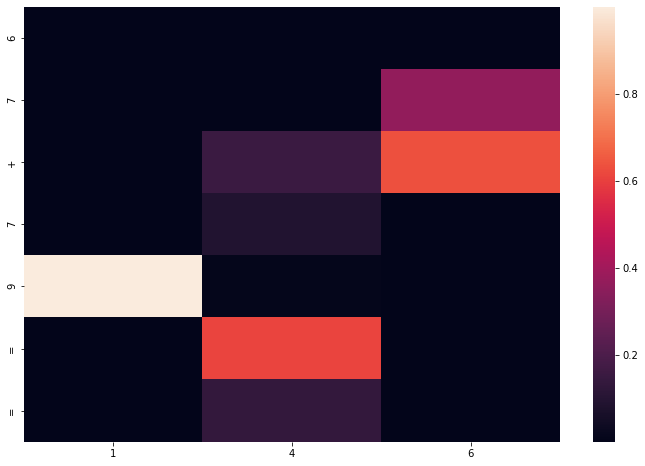

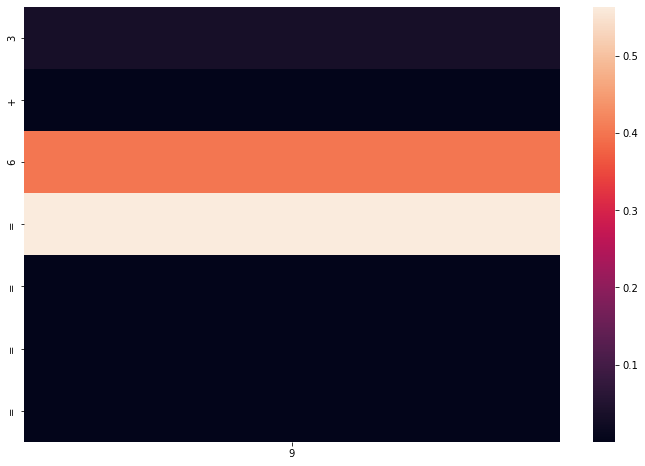

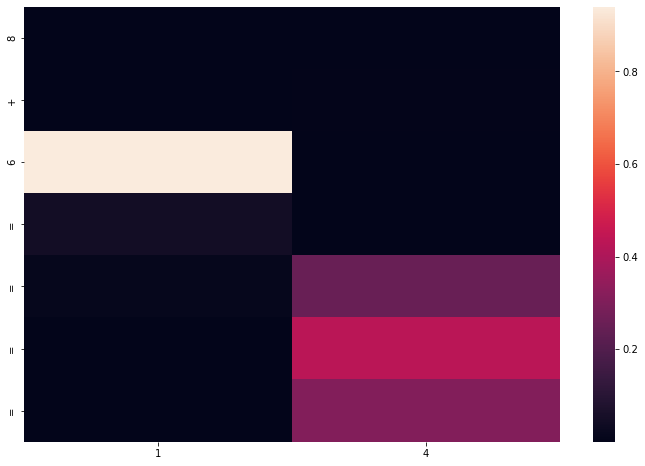

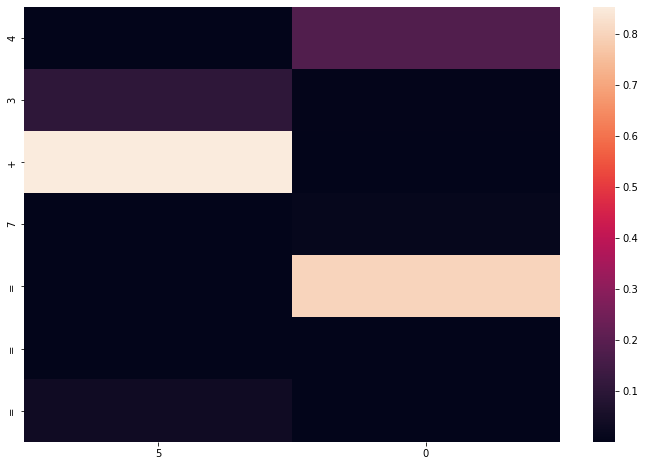

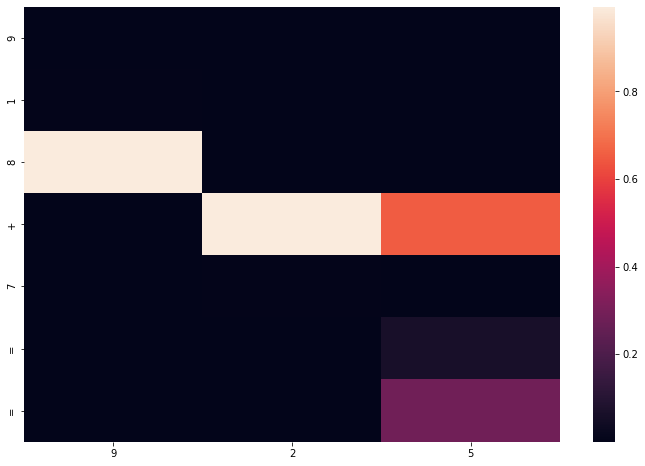

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

batch_size = 1
test_data = CalcDataset(data_num = 2000)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

encoder = Encoder(vocab_size, embedding_dim, hidden_dim, batch_size=1).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim, batch_size=1).to(device)

model_name = "seq2seq_calculator_v{}.pt".format(epoch)
checkpoint = torch.load(model_name)
encoder.load_state_dict(checkpoint["encoder_model"])
decoder.load_state_dict(checkpoint["decoder_model"])

accuracy = 0
        
# 評価の実行   
with torch.no_grad():
    for ind, (data, label) in enumerate(test_loader):
        if use_cuda:
            data = data.cuda()

        hs, state = encoder(data)

        right = []
        Atten = []
        token = "<eos>"
        for _ in range(7):
            index = word2id[token]
            input_tensor = torch.tensor([index], device=device)
            output, state, attention_weight = decoder(input_tensor, hs, state)
            prob = F.softmax(torch.squeeze(output))
            index = torch.argmax(prob.cpu().detach()).item()
            token = id2word[index]
            if token == "<eos>":
                break
            right.append(token)
            Atten.append(attention_weight.cpu().detach().numpy())
        str_right = right
        right = "".join(right)
        
        x = list(data[0].to('cpu').detach().numpy() )
        try:
            padded_idx_x = x.index(word2id["<pad>"])
        except ValueError:
            padded_idx_x = len(x)
        left = "".join(map(lambda c: str(id2word[c]), x[:padded_idx_x]))
        str_left = []
        for s in range(len(x)):
          if str(x[s]) == '11':
            str_left.append('+')
          elif str(x[s]) == '10':
            str_left.append('=')
          else:
            str_left.append(str(x[s]))

        flag = ["F", "T"][eval(left) == int(right)]
        print("{:>7s} = {:>4s} :{}".format(left, right, flag))
        Atten = np.concatenate(Atten, axis=0)
        Atten = Atten[:, :, 0].transpose(1, 0)
        df = pd.DataFrame(Atten, index=str_left, columns=str_right)
        plt.figure(figsize=[12, 8])
        sns.heatmap(df)
        if ind == 4:
          sys.exit()


# 課題
* 四則演算を変えてみよう